In [1]:
import pandas as pd
import numpy as np
import zipfile
from io import TextIOWrapper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 1. Read all CSVs inside the zip file
zip_path = 'C:/Users/LENOVO/Desktop/CIC-IDS-2017.zip'  # Change to your actual file name
dfs = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for file in z.namelist():
        if file.endswith('.csv'):
            print(f"Loading {file}")
            with z.open(file) as f:
                df_part = pd.read_csv(TextIOWrapper(f, 'utf-8'), low_memory=False)
                dfs.append(df_part)


Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loading Friday-WorkingHours-Morning.pcap_ISCX.csv
Loading Monday-WorkingHours.pcap_ISCX.csv
Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loading Tuesday-WorkingHours.pcap_ISCX.csv
Loading Wednesday-workingHours.pcap_ISCX.csv


In [3]:
# 2. Combine all files into one DataFrame
df = pd.concat(dfs, ignore_index=True)


In [4]:
# 3. Clean column names (remove spaces, special characters)
df.columns = df.columns.str.strip()

# Check if 'Label' exists now
if 'Label' not in df.columns:
    raise KeyError("The 'Label' column was not found in the dataset.")

In [5]:

# 4. Remove rows with missing/infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [6]:
# 5. Remove constant columns (e.g., columns with only one value)
df = df.loc[:, df.apply(pd.Series.nunique) > 1]

# 6. Encode the labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [7]:

# 7. Separate features and target
X = df.drop('Label', axis=1)
y = df['Label']

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [8]:
# 9. Define ML pipeline (scaling + classifier)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# 10. Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])


Classification Report:
                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00    454265
                       Bot       0.87      0.77      0.82       391
                      DDoS       1.00      1.00      1.00     25605
             DoS GoldenEye       1.00      0.99      1.00      2059
                  DoS Hulk       1.00      1.00      1.00     46025
          DoS Slowhttptest       0.99      0.99      0.99      1100
             DoS slowloris       1.00      1.00      1.00      1159
               FTP-Patator       1.00      1.00      1.00      1587
                Heartbleed       1.00      1.00      1.00         2
              Infiltration       1.00      0.57      0.73         7
                  PortScan       0.99      1.00      0.99     31761
               SSH-Patator       1.00      1.00      1.00      1180
  Web Attack � Brute Force       0.74      0.82      0.78       301
Web Attack � Sql Inject

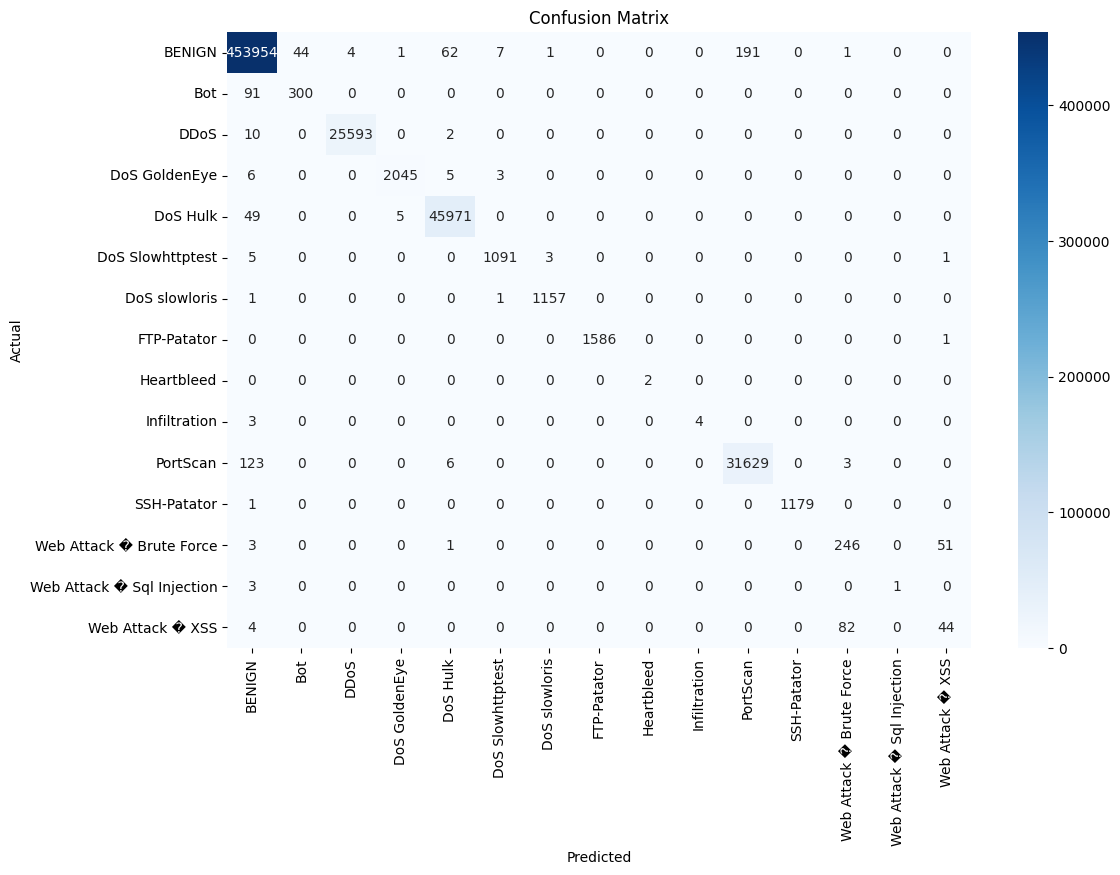

In [9]:
# 11. Make predictions
y_pred = pipeline.predict(X_test)

# 12. Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 13. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()